# Creación directorio proyecto

# Estrategia 1: Modelo desde cero (from scratch)

## Imports

In [1]:
import pandas as pd
import numpy as np
import cv2
import json
import random

from matplotlib import pyplot as plt
from matplotlib import image as img
np.random.seed(46)

from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Concatenate, Input
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam

## Carga de datos

In [2]:
def read_image(path):
    return plt.imread(path)

(480, 640)


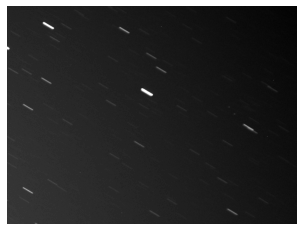

In [3]:
example_image=read_image('E:/Universidad/TFM-DATOS/train/1/1.png')
print(example_image.shape)
plt.imshow(example_image, cmap='gray')
plt.axis('off')
plt.show()

## Reading the annotation file

In [4]:
def read_annotation_file(path):
    with open(path) as annotation_file:
        annotation_list = json.load(annotation_file)
    # Transform list of annotations into dictionary
    annotation_dict = {}
    for annotation in annotation_list:
        sequence_id = annotation['sequence_id']
        if sequence_id not in annotation_dict:
            annotation_dict[sequence_id] = {}
        annotation_dict[sequence_id][annotation['frame']] = annotation['object_coords']
    return annotation_dict

This creates a dictionary where the first key is the sequence id, and the second key is the frame id, which contains a list of the annotation points as lists of floating numbers. For example sequence \#1 shown above contains 3 objects, which are visible in both frames \#1 and \#3.

In [5]:
train_annotation=read_annotation_file('E:/Universidad/TFM-DATOS/train_anno.json')
print(train_annotation[1][1])
print(train_annotation[1][3])

[[502.40625, 237.11458333333337], [490.3818359375, 221.8115234375], [140.87433155080203, 129.09358288770056]]
[[558.40625, 191.11458333333337], [546.3818359375, 175.8115234375], [195.19050802139031, 85.93516042780749]]


# Training a supervised classifier
The idea here is to perform a pixel-wise classification of the image. The training set is generated using the annotations to produce two classes, "1" which represents the geostationary satellites, and "0" which represents their absence.
## Generating labeled data for supervised classification

Next we can generate a training data set using the annotations and the images. For each annotated object, we wish to extract the value of the corresponding pixel in the image, along with the neighboring pixels within a square window of selectable size. Moreover, we will randomly select an arbitrary number of false samples (pixels that contain no satellites) in each image, under the condition that they are different from the training samples.

In [6]:
def random_different_coordinates(coords, size_x, size_y, pad):
    """ Returns a random set of coordinates that is different from the provided coordinates, 
    within the specified bounds.
    The pad parameter avoids coordinates near the bounds."""
    good = False
    while not good:
        good = True
        c1 = random.randint(pad + 1, size_x - (pad + 1))
        c2 = random.randint(pad + 1, size_y -( pad + 1))
        for c in coords:
            if c1 == c[0] and c2 == c[1]:
                good = False
                break
    return (c1,c2)

def extract_neighborhood(x, y, arr, radius):
    """ Returns a 1-d array of the values within a radius of the x,y coordinates given """
    return arr[(x - radius) : (x + radius + 1), (y - radius) : (y + radius + 1)].ravel()

def check_coordinate_validity(x, y, size_x, size_y, pad):
    """ Check if a coordinate is not too close to the image edge """
    return x >= pad and y >= pad and x + pad < size_x and y + pad < size_y

def generate_labeled_data(image_path, annotation, nb_false, radius):
    """ For one frame and one annotation array, returns a list of labels 
    (1 for true object and 0 for false) and the corresponding features as an array.
    nb_false controls the number of false samples
    radius defines the size of the sliding window (e.g. radius of 1 gives a 3x3 window)"""
    features,labels = [],[]
    im_array = read_image(image_path)
    # True samples
    for obj in annotation:
        obj = [int(x + .5) for x in obj] #Project the floating coordinate values onto integer pixel coordinates.
        # For some reason the order of coordinates is inverted in the annotation files
        if check_coordinate_validity(obj[1],obj[0],im_array.shape[0],im_array.shape[1],radius):
            features.append(extract_neighborhood(obj[1],obj[0],im_array,radius))
            labels.append(1)
    # False samples
    for i in range(nb_false):
        c = random_different_coordinates(annotation,im_array.shape[1],im_array.shape[0],radius)
        features.append(extract_neighborhood(c[1],c[0],im_array,radius))
        labels.append(0)
    return np.array(labels),np.stack(features,axis=1)

Now we have a function for generating the data for one frame. We can loop this function to generate the labeled data for a list of sequences.

In [7]:
def generate_labeled_set(annotation_array, path, sequence_id_list, radius, nb_false):
    # Generate labeled data for a list of sequences in a given path
    labels,features = [],[]
    for seq_id in sequence_id_list:
        for frame_id in range(1,6):
            d = generate_labeled_data(f"{path}{seq_id}/{frame_id}.png",
                                    annotation_array[seq_id][frame_id],
                                    nb_false,
                                    radius)
            labels.append(d[0])
            features.append(d[1])
    return np.concatenate(labels,axis=0), np.transpose(np.concatenate(features,axis=1))

In [8]:
radius=3
y_train, X_train = generate_labeled_set(train_annotation,'E:/Universidad/TFM-DATOS/train/', range(1,101), radius, 10)
print("TRAIN")
print(y_train.shape)
print(y_train)
print(X_train.shape)
print("")
print("TEST")
y_test, X_test = generate_labeled_set(train_annotation,'E:/Universidad/TFM-DATOS/train/', range(101,106), radius, 500)
print(y_test.shape)
print(y_test)
print(X_test.shape)

TRAIN
(5971,)
[1 1 1 ... 0 0 0]
(5971, 49)

TEST
(12575,)
[0 0 0 ... 0 0 0]
(12575, 49)


In [9]:
print(X_test[0].size)
print(X_test[0])

49
[0.27450982 0.29803923 0.29803923 0.2784314  0.2784314  0.28235295
 0.2901961  0.2901961  0.2784314  0.29803923 0.27450982 0.29411766
 0.29411766 0.29803923 0.28627452 0.29803923 0.28235295 0.27450982
 0.2784314  0.28235295 0.3019608  0.2901961  0.29411766 0.2901961
 0.28235295 0.29411766 0.29411766 0.3019608  0.27058825 0.28627452
 0.28627452 0.28235295 0.27450982 0.28627452 0.2784314  0.28235295
 0.28627452 0.2784314  0.2901961  0.27450982 0.28627452 0.2901961
 0.28235295 0.29803923 0.2901961  0.28235295 0.28235295 0.29411766
 0.29803923]


In [53]:
def get_scaled_imgs(list):
    imgs = []
    
    for i in list:
        #hacer la imágen de 75x75 pixeles
        img = i.reshape((7,7))
        
        imgs.append(img)
    
    img_3 = np.expand_dims(imgs, axis=3)
    return np.array(img_3)

(5971, 7, 7, 1)


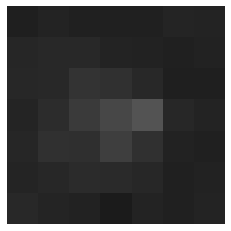

In [54]:
X_train_reesc = get_scaled_imgs(X_train)
print(X_train_reesc.shape)
plt.imshow(X_train_reesc[0], cmap='gray',vmin=0,vmax=1)
plt.axis('off')
plt.show()

This has genered 5971 samples : 971 true and 5000 false (100 sequences, 5 frames per sequence, 10 random false samples per frame). We can reshape the 49 features in a 7x7 window for visualization.
Example of a true sample:

1


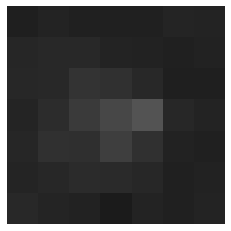

In [55]:
print(y_train[0])
plt.imshow(X_train[0].reshape((7,7)), cmap='gray',vmin=0,vmax=1)
plt.axis('off')
plt.show()

Example of a false sample:

(12575, 7, 7, 1)


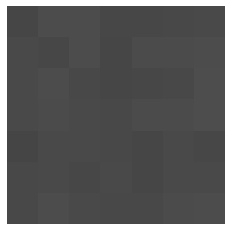

In [56]:
X_test_reesc = get_scaled_imgs(X_test)
print(X_test_reesc.shape)
plt.imshow(X_test_reesc[0], cmap='gray',vmin=0,vmax=1)
plt.axis('off')
plt.show()

0


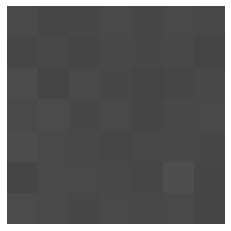

In [57]:
print(y_test[5])
plt.imshow(X_test[5].reshape((7,7)), cmap='gray',vmin=0,vmax=1)
plt.axis('off')
plt.show()

Se realiza una partición de los datos para dividirlos en el conjunto de entrenamiento y en el conjunto de validación

In [ ]:
# Data augmentation
Xtr_more = data_augmentation(X_train) 
Ytr_more = np.concatenate((y_train,y_train,y_train))
X_inc_train_more = np.concatenate((X_inc_train,X_inc_train,X_inc_train))
X_test_more = data_augmentation(X_test)
X_inc_test_more = np.concatenate((X_inc_test,X_inc_test,X_inc_test))
y_test_more = np.concatenate([y_test, y_test, y_test])

Con el único fin de poder visualizar como son las imágenes que se utilizaran para el entrenamiento, se muestran 3 imágenes escogidas aleatoriamente

## Creación de la arquitectura

Se ha escogido una arquitectura compuesta por 3 capas convolucionales junto con 2 sets de capas FC

La estructura de cada capa convolucional es la misma, están compuestas por una capa convolucional 2D con un kernel size de 3x3 y todas utilizan el método de activación relu

Además, se ha utilizado un MaxPooling con strides 2x2

Por último, se ha decidido utilizar Dropout en cada capa para evitar aún más el overffiting

En cuanto a las capas FC, se ha decidido por una estructura descendente desde una entrada de 512 características y acabando en una salida de un filtro y activación sigmoide ya que solo debe decidir si es iceberg lo que hay en la imágen o es barco

In [38]:
def getModel1():

    model=Sequential()

    # CNN 1
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(7, 7, 1), padding='same'))
    #model.add(BatchNormalization())
    #model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    #model.add(Dropout(0.2))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
#     # CNN 2
#     model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
#     #model.add(BatchNormalization())
#     model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
#     model.add(Dropout(0.2))

#     # CNN 3
#     model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
#     #model.add(BatchNormalization())
#     model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
#     model.add(Dropout(0.3))

    model.add(Flatten())

    #Dense 1
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))

    #Dense 2
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))

    # Output 
    model.add(Dense(1, activation="sigmoid"))

    optimizer = Adam(learning_rate=0.001, decay=0.0)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

## Entrenamiento de la arquitectura

Se ha decidido entrenar a la arquitectura mediante 50 epocas y un batch size de 32, además se ha utilizado anteriormente la función train_test_split para conseguir datos de validación

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 7, 7, 32)          320       
                                                                 
 conv2d_14 (Conv2D)          (None, 5, 5, 64)          18496     
                                                                 
 conv2d_15 (Conv2D)          (None, 3, 3, 128)         73856     
                                                                 
 flatten_5 (Flatten)         (None, 1152)              0         
                                                                 
 dense_15 (Dense)            (None, 512)               590336    
                                                                 
 dropout_14 (Dropout)        (None, 512)               0         
                                                                 
 dense_16 (Dense)            (None, 256)              

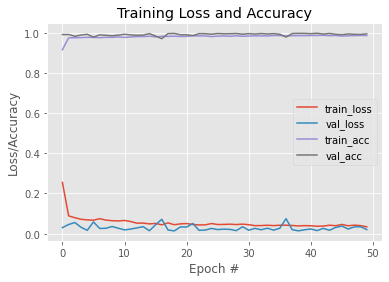

In [42]:
model = getModel1()
model.summary()

#------------------------------------------------------------------------------------------------------------------------------------------------------

history = model.fit(X_train_reesc_3, y_train, epochs=50, batch_size=32, validation_data=(X_test_reesc_3, y_test))
model.save_weights('E:/Universidad/TFM-DATOS/saves/weights1.model')

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 50), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, 50), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 50), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 50), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

In [82]:
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(n_estimators=500, max_depth=30, random_state=0)
RF.fit(X_train, y_train)

RandomForestClassifier(max_depth=30, n_estimators=500, random_state=0)

In [62]:
y_test_prueba, X_test_prueba = generate_labeled_set(train_annotation,'E:/Universidad/TFM-DATOS/train/', range(106,110), radius, 500)

X_test_prueba = get_scaled_imgs(X_test_prueba)

results = model.evaluate(X_test_prueba, y_test_prueba, batch_size=128)

79/79 [==============================] - 0s 4ms/step - loss: 0.0279 - accuracy: 0.9918


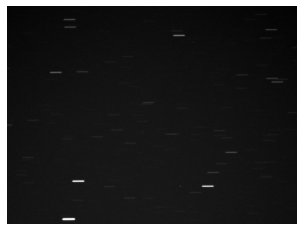

(480, 640)

In [66]:
sequence_id, frame_id = 102, 1
target_image = plt.imread(f"E:/Universidad/TFM-DATOS/train/{sequence_id}/{frame_id}.png")
plt.imshow(target_image, cmap='gray')
plt.axis('off')
plt.show()
target_image.shape

In [83]:
def classify_image(im, model, radius):
    n_features=(2*radius+1)**2 #Total number of pixels in the neighborhood
    feat_array=np.zeros((im.shape[0],im.shape[1],n_features))
    for x in range(radius+1,im.shape[0]-(radius+1)):
        for y in range(radius+1,im.shape[1]-(radius+1)):
            feat_array[x,y,:]=extract_neighborhood(x,y,im,radius)
    all_pixels=feat_array.reshape(im.shape[0]*im.shape[1],n_features)
    print(all_pixels.shape)
    #all_pixels=get_scaled_imgs(all_pixels)
    print(all_pixels.shape)
    pred_pixels=model.predict(all_pixels).astype(np.bool_)
    pred_image=pred_pixels.reshape(im.shape[0],im.shape[1])
    return pred_image

In [84]:
pred_image=classify_image(target_image, RF, radius)

(307200, 49)
(307200, 49)


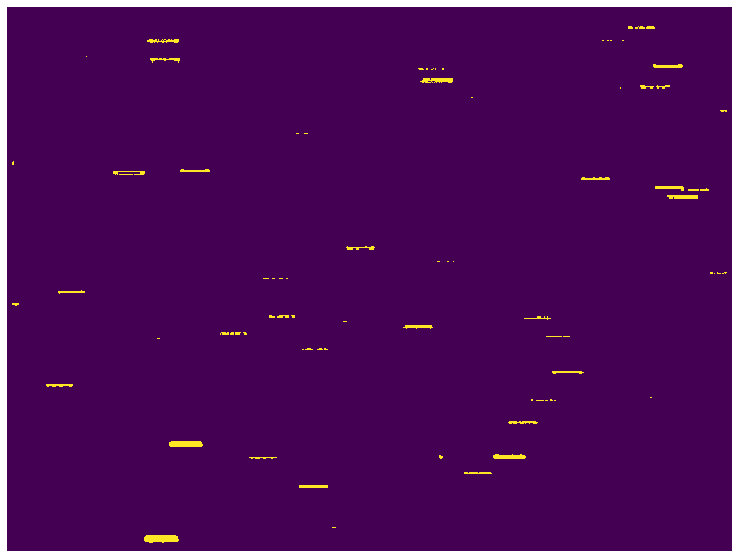

In [85]:
plt.figure(figsize=(15,10))
plt.imshow(pred_image, interpolation='None')
plt.axis('off')
plt.show()